<a href="https://colab.research.google.com/github/albinwan/algorithmic-trading-python/blob/master/02_EDA_and_Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [81]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import ttest_ind
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

# some matplotlib params to make the defaults a bit more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [82]:
# Read in all relevant datasets
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')
weather = pd.read_csv('/content/weather.csv')
spray = pd.read_csv('/content/spray.csv')

In [83]:
test.shape

(35411, 29)

# New section

Take a look at the shapes of the datasets

In [3]:
print("test.csv shape: ", test.shape)
print("train.csv shape: ", train.shape)
print("weather.csv shape: ", weather.shape)
print("spray.csv shape: ", spray.shape)

test.csv shape:  (116293, 29)
train.csv shape:  (8475, 30)
weather.csv shape:  (1472, 22)
spray.csv shape:  (14294, 4)


In [4]:
train.head()

,Date,Trap,Latitude,Longitude,Species,Block,AddressAccuracy,NumMosquitos,WnvPresent,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Heat/Cool,sunset,sunrise,SunHours,isRainy,Humidity
0,2007-05-29,T002,41.954690,-87.800991,CULEX PIPIENS/RESTUANS,41,9,1,0,88,62.5,75.25,10.0,58,65.0,421,1917,BR HZ,0.0,29.415,30.11,5.8,18,6.5,10.25,2007-05-29 19:17:00,2007-05-29 04:21:00,896.0,0,55.05
1,2007-05-29,T002,41.954690,-87.800991,CULEX RESTUANS,41,9,1,0,88,62.5,75.25,10.0,58,65.0,421,1917,BR HZ,0.0,29.415,30.11,5.8,18,6.5,10.25,2007-05-29 19:17:00,2007-05-29 04:21:00,896.0,0,55.05
2,2007-05-29,T007,41.994991,-87.769279,CULEX RESTUANS,62,9,1,0,88,62.5,75.25,10.0,58,65.0,421,1917,BR HZ,0.0,29.415,30.11,5.8,18,6.5,10.25,2007-05-29 19:17:00,2007-05-29 04:21:00,896.0,0,55.05
3,2007-05-29,T015,41.974089,-87.824812,CULEX PIPIENS/RESTUANS,79,8,1,0,88,62.5,75.25,10.0,58,65.0,421,1917,BR HZ,0.0,29.415,30.11,5.8,18,6.5,10.25,2007-05-29 19:17:00,2007-05-29 04:21:00,896.0,0,55.05
4,2007-05-29,T015,41.974089,-87.824812,CULEX RESTUANS,79,8,4,0,88,62.5,75.25,10.0,58,65.0,421,1917,BR HZ,0.0,29.415,30.11,5.8,18,6.5,10.25,2007-05-29 19:17:00,2007-05-29 04:21:00,896.0,0,55.05


## Edits prior to train/validation split 

Add in columns to differentiate the date features (year-mth/year/month/week)

In [5]:
train['Date'] = pd.to_datetime(train['Date'])
train['year-mth']= pd.to_datetime(train['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


# Train/validation split

We want to convert our dataset from A to B, creating a validation set so that we can validate how well our model performs.

![](https://upload.wikimedia.org/wikipedia/commons/b/bb/ML_dataset_training_validation_test_sets.png)

In [6]:
X = train.drop(columns=['WnvPresent'])
y = train['WnvPresent']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

We also want a dataset with target variable in order for us to do EDA

In [7]:
X_train_EDA = X_train.copy()
X_train_EDA['WnvPresent'] = y_train

# Imputations

We find that there are null values for `StnPressure`. We inpute with the median.

In [8]:
X_train.isnull().sum().sort_values(ascending=False).head()

StnPressure    54
Week            0
Tmax            0
WetBulb         0
DewPoint        0
dtype: int64

In [9]:
X_train['StnPressure'].fillna(X_train['StnPressure'].median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Impute validation and test set with values from train set in order to prevent data leakage

In [10]:
X_val['StnPressure'].fillna(X_train['StnPressure'].median(), inplace=True)
test['StnPressure'].fillna(X_train['StnPressure'].median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


# EDA

In [11]:
for col in X_train_EDA:
    print(f'{col} column count of unique values: {len(X_train_EDA[col].unique())}')

Date column count of unique values: 95
Trap column count of unique values: 136
Latitude column count of unique values: 138
Longitude column count of unique values: 138
Species column count of unique values: 7
Block column count of unique values: 145
AddressAccuracy column count of unique values: 43
NumMosquitos column count of unique values: 193
Tmax column count of unique values: 33
Tmin column count of unique values: 48
Tavg column count of unique values: 64
Depart column count of unique values: 28
DewPoint column count of unique values: 32
WetBulb column count of unique values: 31
Sunrise column count of unique values: 62
Sunset column count of unique values: 58
CodeSum column count of unique values: 19
PrecipTotal column count of unique values: 30
StnPressure column count of unique values: 59
SeaLevel column count of unique values: 41
ResultSpeed column count of unique values: 62
ResultDir column count of unique values: 34
AvgSpeed column count of unique values: 61
Heat/Cool column

In [12]:
X_train.dtypes

Date               datetime64[ns]
Trap                       object
Latitude                  float64
Longitude                 float64
Species                    object
Block                       int64
AddressAccuracy             int64
NumMosquitos                int64
Tmax                        int64
Tmin                      float64
Tavg                      float64
Depart                    float64
DewPoint                    int64
WetBulb                   float64
Sunrise                     int64
Sunset                      int64
CodeSum                    object
PrecipTotal               float64
StnPressure               float64
SeaLevel                  float64
ResultSpeed               float64
ResultDir                   int64
AvgSpeed                  float64
Heat/Cool                 float64
sunset                     object
sunrise                    object
SunHours                  float64
isRainy                     int64
Humidity                  float64
year-mth      

In [13]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,5678.0,41.845055,0.106624,41.644612,41.750498,41.862292,41.944869,42.017430
Longitude,5678.0,-87.694506,0.084245,-87.930995,-87.752411,-87.694991,-87.642984,-87.531635
Block,5678.0,44.176647,34.935900,10.000000,17.000000,39.000000,61.000000,540.000000
AddressAccuracy,5678.0,9.609898,9.738965,3.000000,8.000000,8.000000,9.000000,306.000000
NumMosquitos,5678.0,15.340085,65.413410,1.000000,2.000000,4.000000,11.000000,2207.000000
Tmax,5678.0,81.280733,8.338156,57.000000,78.000000,83.000000,87.000000,96.000000
Tmin,5678.0,63.143625,7.589431,42.500000,59.000000,64.500000,69.000000,77.500000
Tavg,5678.0,72.212179,7.499392,50.750000,68.000000,73.500000,78.000000,84.750000
Depart,5678.0,2.497534,6.611005,-12.000000,-2.000000,3.500000,7.000000,18.000000
DewPoint,5678.0,59.422860,7.899890,39.000000,54.000000,59.000000,67.000000,73.000000


## West Nile Virus

Let's look at what's the percentage of the full population that contains the West Nile Virus.

Text(0, 0.5, 'Frequency')

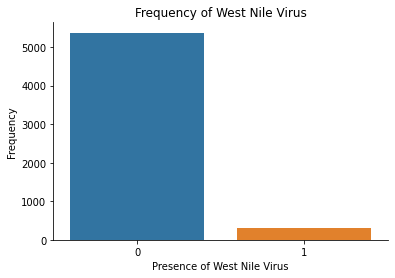

In [14]:
wnv_count = pd.DataFrame(X_train_EDA['WnvPresent'].value_counts())

sns.barplot(x=wnv_count.index, y=wnv_count['WnvPresent'])
plt.title('Frequency of West Nile Virus')
plt.xlabel('Presence of West Nile Virus')
plt.ylabel('Frequency')

In [15]:
X_train_EDA['WnvPresent'].value_counts(normalize=True)

0    0.946108
1    0.053892
Name: WnvPresent, dtype: float64

5% of the train data set contains the West Nile Virus. Considering the small presence, one option we can consider is to use SMOTE as part of our modelling technique. We will explore this in the modelling section.

## Number of mosquitoes

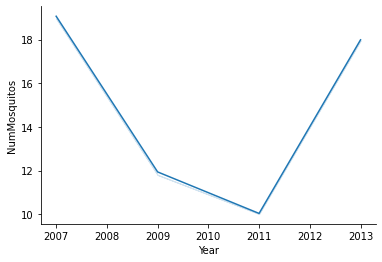

In [16]:
# this is our plot during 'exploring' the data, i think can removed
sns.lineplot(x = "Year", y = "NumMosquitos", data = X_train, ci=False);

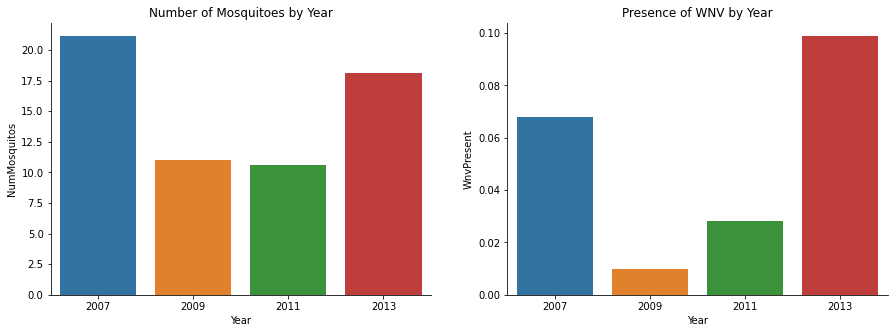

In [17]:
#lineplot based on dates
fig, axes = plt.subplots(1, 2, figsize=(15, 5));

sns.barplot(ax=axes[0], x = 'Year', y= 'NumMosquitos', data=train, ci=False);
axes[0].set_title("Number of Mosquitoes by Year");


sns.barplot(ax=axes[1], x = 'Year', y= 'WnvPresent', data=train, ci=False);
axes[1].set_title("Presence of WNV by Year");

In [18]:
#lineplot based on week of year
#this is the no of datapoints per week of year
#train.Date.dt.week.hist();

#####plot west nile over this plot

## Species

We want to take a look at data for mosquito species to see if there are any specific breeds which have a higher tendency to harbour the West Nile Virus

In [19]:
species_eda = X_train_EDA[['Species', 'NumMosquitos', 'WnvPresent']].groupby('Species').sum()
species_eda['WnvPresent_Pct'] = species_eda['WnvPresent'] / species_eda['NumMosquitos'] * 100
species_eda = species_eda.sort_values(by='WnvPresent', ascending=False)
species_eda

,NumMosquitos,WnvPresent,WnvPresent_Pct
Species,,,
CULEX PIPIENS/RESTUANS,45309,146,0.322232
CULEX PIPIENS,25768,127,0.492859
CULEX RESTUANS,15625,33,0.211200
CULEX ERRATICUS,7,0,0.000000
CULEX SALINARIUS,97,0,0.000000
CULEX TARSALIS,2,0,0.000000
CULEX TERRITANS,293,0,0.000000


It looks like the bulk of the breeds captured belong to either Culex Restuans or Culex Pipiens. It also looks like there's a group of species which may be either - perhaps the breed could not be determined.

Text(0.5, 0, 'Count')

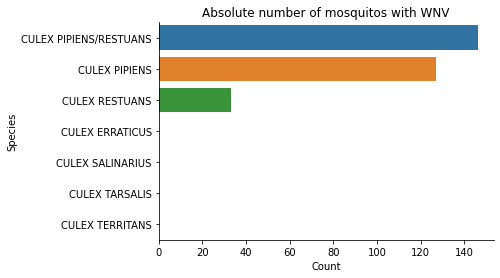

In [20]:
sns.barplot(data=species_eda, y=species_eda.index, x=species_eda['WnvPresent'], orient='h')
plt.title('Absolute number of mosquitos with WNV')
plt.xlabel('Count')

Text(0.5, 0, 'Percent')

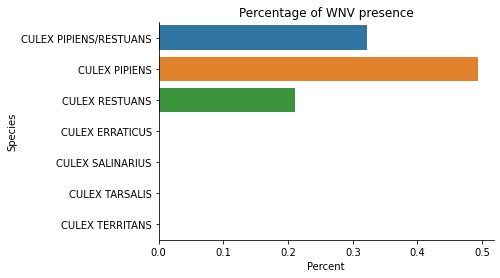

In [21]:
sns.barplot(data=species_eda, y=species_eda.index, x=species_eda['WnvPresent_Pct'], orient='h')
plt.title('Percentage of WNV presence')
plt.xlabel('Percent')

It can be observed that Culex Pipiens has the highest tendency to harbour the West Nile Virus (0.5% of the mosquito breed would typically contain the virus).

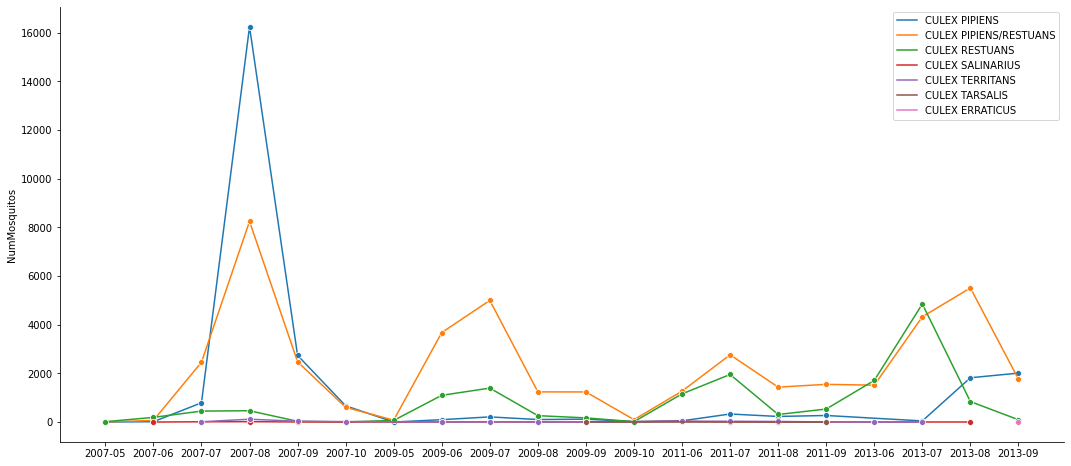

In [22]:
yrmth_spec_group = X_train_EDA.groupby(['year-mth', 'Species']).sum()

x_index_yrmth = [keys for keys, values in yrmth_spec_group.index]
hue_spec = [values for keys, values in yrmth_spec_group.index]

plt.figure(figsize=(18,8))
sns.lineplot(x = x_index_yrmth, y = "NumMosquitos", data =yrmth_spec_group.sort_index(level=0), ci=False, hue=hue_spec, marker='o')
plt.legend()
plt.xticks(fontsize=10);
# can start to observe that the number of mosquitoes are different for different location

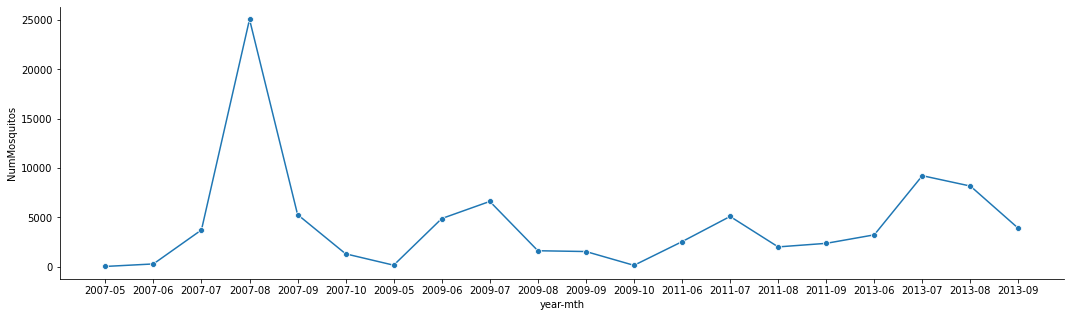

In [23]:
yrmth_group = X_train_EDA.groupby(['year-mth']).sum()

plt.figure(figsize=(18,5))
sns.lineplot(x = yrmth_group.index  , y = "NumMosquitos", data = yrmth_group ,marker='o', ci=False)
plt.xticks(fontsize=10);
#need to reduce the tick size... no space lol

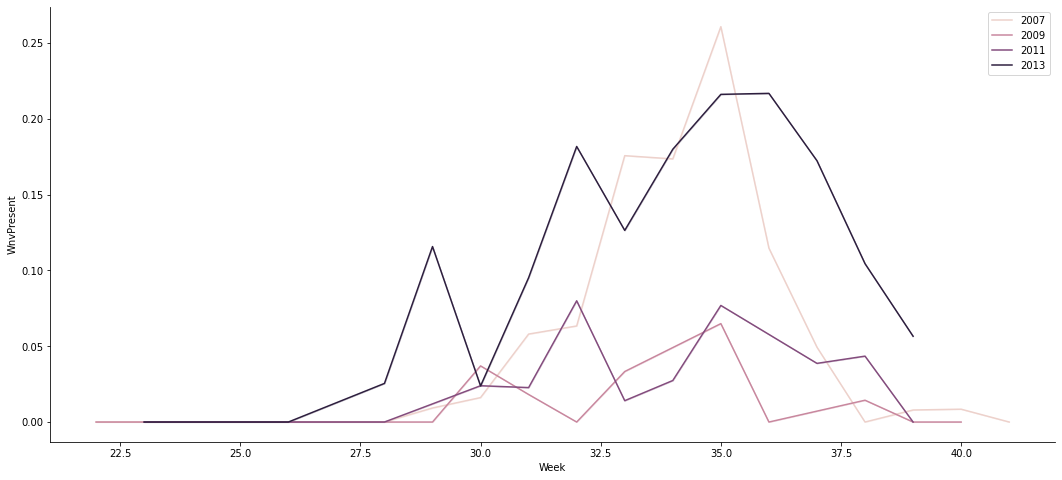

In [24]:
plt.figure(figsize=(18,8))
sns.lineplot(x = "Week", y = "WnvPresent", data = X_train_EDA, ci=False, hue='Year')
plt.legend()
plt.xticks(fontsize=10);

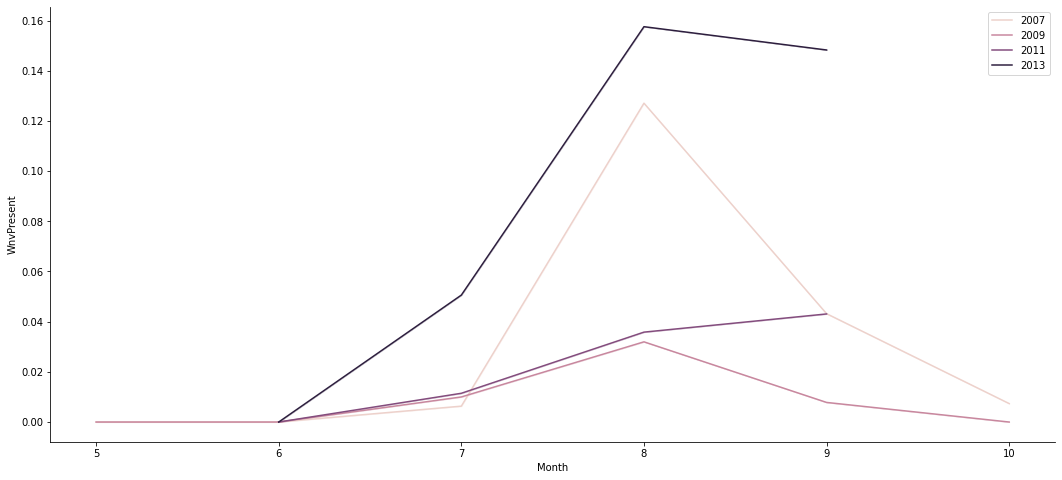

In [25]:
plt.figure(figsize=(18,8))
sns.lineplot(x = "Month", y = "WnvPresent", data = X_train_EDA, ci=False, hue='Year')
plt.legend()
plt.xticks(fontsize=10);

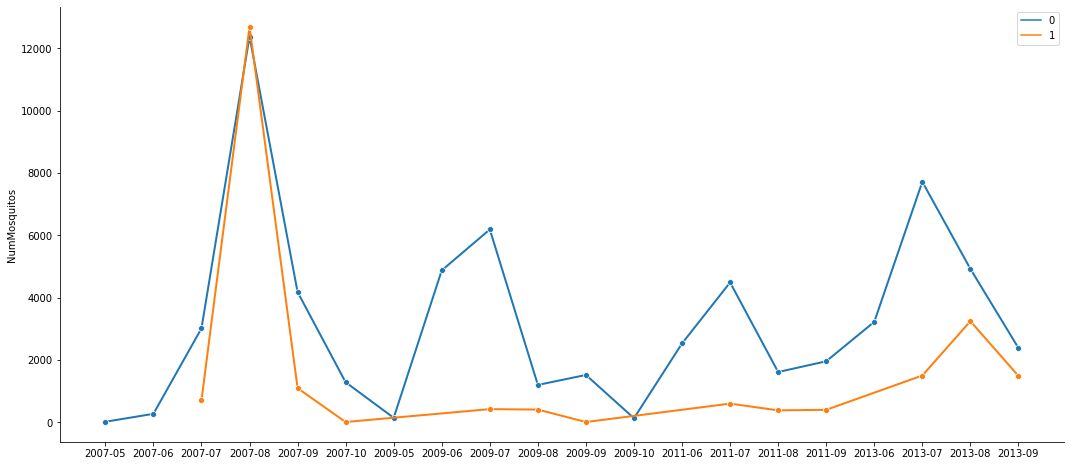

In [26]:
yrmth_wnv_group = X_train_EDA.groupby(['year-mth', 'WnvPresent']).sum()

x_index_yrmth = [keys for keys, values in yrmth_wnv_group.index]
hue_wnv = [values for keys, values in yrmth_wnv_group.index]

# hue = 'WnvPresent'

plt.figure(figsize=(18,8))
sns.lineplot(x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
plt.legend()
plt.xticks(fontsize=10);
# can start to observe that the number of mosquitoes are different for different location

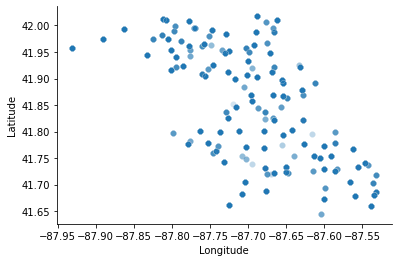

In [27]:
# decided to plot the scatter plot latitude, y=longitude

sns.scatterplot(data=X_train_EDA, x="Longitude", y="Latitude", alpha=0.1, )

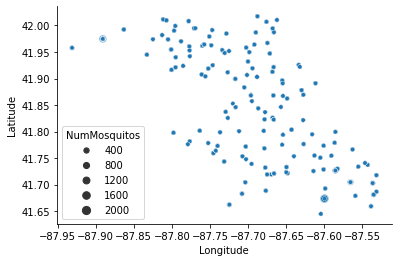

In [28]:
# this is not a good plot, i think can use the 'map' version, because latitude and longitude are only at 2 decimal places
# exploring the size keyword, bigger size means more mosquitoes at the Latitude,Longitude
sns.scatterplot(data=X_train_EDA, x="Longitude", y="Latitude", size='NumMosquitos');

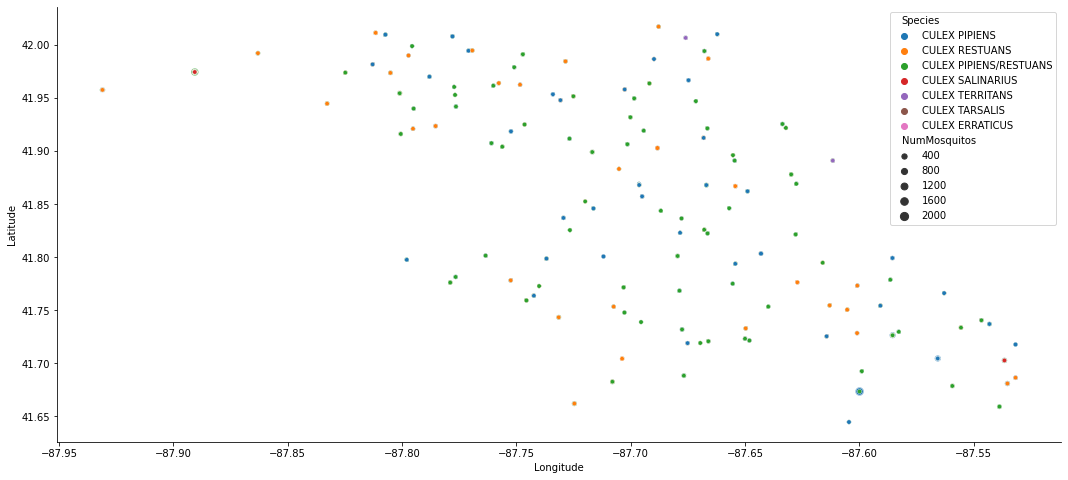

In [29]:
# this plot rather confusing and hard to intepret as different species can be in the same latitude/longitude
plt.figure(figsize=(18,8))
sns.scatterplot(data=X_train_EDA, x="Longitude", y="Latitude", size='NumMosquitos', hue='Species');

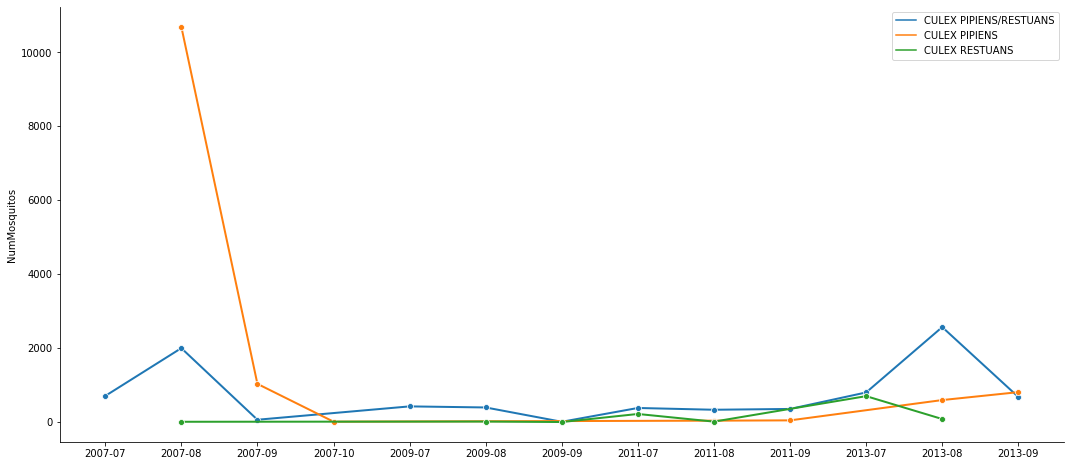

In [30]:
# creating a dataframe for ['WnvPresent']==1
wnv_present = X_train_EDA[X_train_EDA['WnvPresent']==1]

# group by year-mth and 'species'
yrmth_spec_group = wnv_present.groupby(['year-mth', 'Species']).sum()

# year-mth is the first index and will be x-axis
x_index_yrmth = [keys for keys, values in yrmth_spec_group.index]

# species is the 2nd index and will be the hue
hue_spec = [values for keys, values in yrmth_spec_group.index]

plt.figure(figsize=(18,8))
sns.lineplot(x = x_index_yrmth, y = "NumMosquitos", data =yrmth_spec_group.sort_index(level=0), ci=False, hue=hue_spec, marker='o', lw=2)
plt.legend()
plt.xticks(fontsize=10);

In [31]:
# noted that even though that species carry WnvPresent, not all of them carry throughout the timeline
X_train_EDA[X_train_EDA['Species']=='CULEX PIPIENS']['WnvPresent'].value_counts()

0    1167
1     127
Name: WnvPresent, dtype: int64

In [32]:
# Note! no need to show this 
# just something i noted, because i was thinking why the lineplots dont line up for 'CULEX PIPIENS' with WNV
# as compared to 'CULEX PIPIENS' when plotting with and without WNV
X_train_EDA[X_train_EDA['Species']=='CULEX PIPIENS'][['year-mth', 'WnvPresent']].value_counts()

year-mth  WnvPresent
2007-08   0             271
2007-09   0             189
2013-08   0             110
2013-09   0              98
2009-07   0              76
2007-08   1              62
2007-10   0              60
2009-09   0              57
2011-08   0              56
2009-08   0              51
2007-07   0              46
2011-09   0              44
2011-07   0              41
2009-06   0              37
2013-09   1              24
2013-08   1              24
2007-09   1              13
2009-10   0              10
2013-07   0               7
2007-06   0               7
2011-06   0               5
2011-08   1               2
2009-05   0               1
2007-10   1               1
2011-09   1               1
2007-05   0               1
dtype: int64

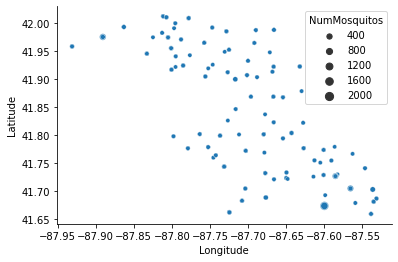

In [33]:
# i think all the scatterplots with longitude and latitude doesnt explain much
sns.scatterplot(data=wnv_present, x="Longitude", y="Latitude", size='NumMosquitos');

In [34]:
# count of traps with 'wnv' as hue

trap_table = pd.DataFrame(X_train_EDA.groupby(['year-mth','WnvPresent' ])['Trap'].count())

<Figure size 1152x288 with 0 Axes>

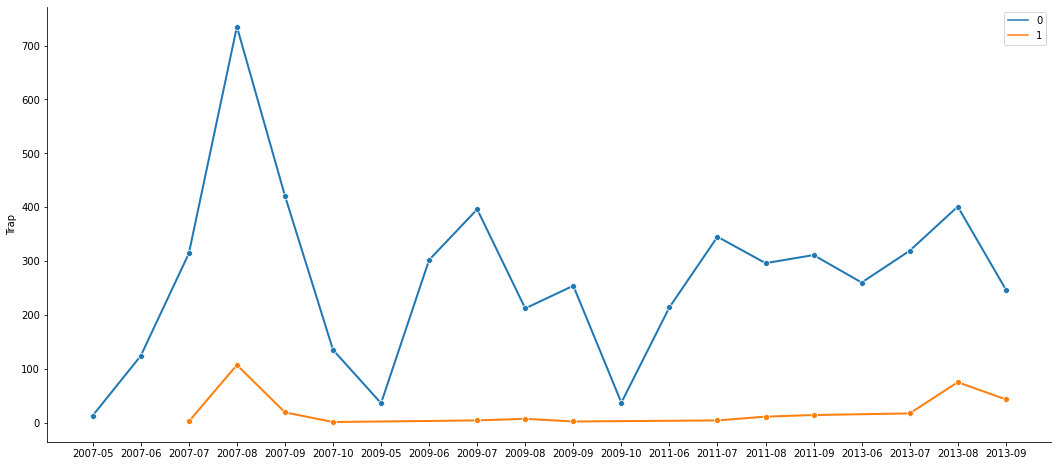

In [35]:
# count of traps with 'wnv' as hue
plt.figure(figsize=(16,4))
trap_table = pd.DataFrame(X_train_EDA.groupby(['year-mth','WnvPresent' ])['Trap'].count())
trap_table


#yrmth_spec_group = wnv_present.groupby(['year-mth', 'Species']).sum()

x_index_yrmth = [keys for keys, values in trap_table.index]
hue_wnv = [values for keys, values in trap_table.index]

plt.figure(figsize=(18,8))
sns.lineplot(x = x_index_yrmth, y = 'Trap', data=trap_table.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
plt.legend()
plt.xticks(fontsize=10);


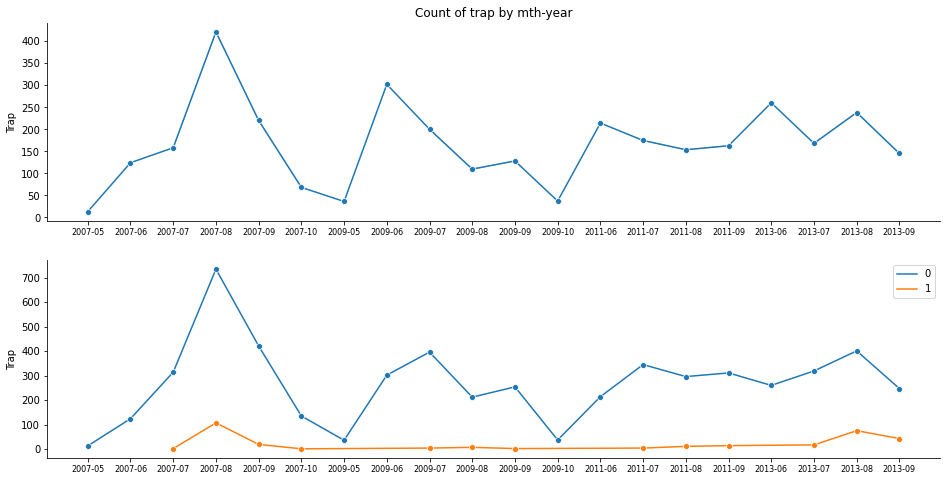

In [36]:
## this is the same as the 2 above, they are the subplot version...
## probably for presentation?

#lineplot based on dates
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharey=False);

sns.lineplot(ax=axes[0], x = x_index_yrmth, y= 'Trap', data=trap_table, ci=False,  marker='o');
axes[0].set_title("Count of trap by mth-year");
#axes[0].tick_params(axis='x', which='minor', labelsize=8)
axes[0].xaxis.set_tick_params(labelsize=8)


sns.lineplot(ax=axes[1], x = x_index_yrmth, y= 'Trap', data=trap_table, ci=False, hue = hue_wnv, marker='o');
#axes[1].set_title("Count of trap by mth-year");
axes[1].xaxis.set_tick_params(labelsize=8)

- from May 2007 to October 2009 (**Note: with time gaps**)there are traps placed in Chicago to capture mosquitoes.
- Not all of the traps placed captured mosquitoes with WNV, with increase in traps, there will be increase in traps with WNV mosquitoes


## Latitude and Longitude

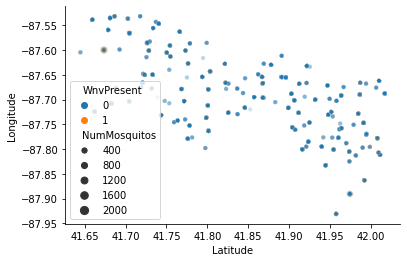

In [37]:
# decided to plot the scatter plot latitude, y=longitude

sns.scatterplot(data=X_train_EDA,x="Latitude", y="Longitude",alpha=0.1, hue='WnvPresent', size='NumMosquitos');

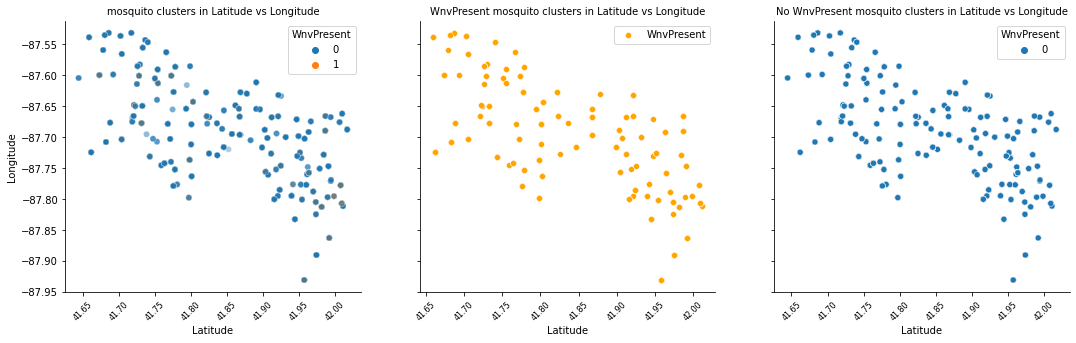

In [38]:
wnv_present = X_train_EDA[X_train_EDA['WnvPresent']==1]
no_wnv_only = X_train_EDA[X_train_EDA['WnvPresent']==0]

#scatterplot based on dates
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True);

sns.scatterplot(ax=axes[0], x="Latitude", y="Longitude", data=X_train_EDA, ci=False, hue='WnvPresent', alpha=0.2, color='green');
axes[0].set_title("mosquito clusters in Latitude vs Longitude", fontsize=10);
axes[0].xaxis.set_tick_params(labelsize=8, rotation=45)

sns.scatterplot(ax=axes[1], x="Latitude", y="Longitude", data=wnv_present, ci=False,color='orange', label='WnvPresent');
axes[1].set_title("WnvPresent mosquito clusters in Latitude vs Longitude",fontsize=10);
axes[1].xaxis.set_tick_params(labelsize=8, rotation=45)

sns.scatterplot(ax=axes[2], x="Latitude", y="Longitude", data=no_wnv_only, ci=False,color='green', hue='WnvPresent');
axes[2].set_title("No WnvPresent mosquito clusters in Latitude vs Longitude",fontsize=10);
axes[2].xaxis.set_tick_params(labelsize=8, rotation=45)

**Note**: i was trying to plot to show that breeding clusters for wnv and wnv not present are different based on Latitude and Longitude, but they are the same???
- From this above plot, we are unable to observe if there are any obvious hotspot for mosquitoes with WNV.
- this could be because breeding spots for mosquitoes with WNV are same with without WNV 

In [39]:
X_train_EDA['WnvPresent'].value_counts()

0    5372
1     306
Name: WnvPresent, dtype: int64

In [40]:
pct_wnv_train = round(X_train_EDA['WnvPresent'].value_counts()[1]/ len(X_train)*100, 4)

print(f" {pct_wnv_train}% of the dataset has observations with West Nile Virus ")

 5.3892% of the dataset has observations with West Nile Virus 


### Scatter plot of Weather conditions vs mosquitos

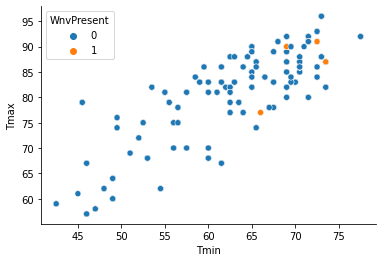

In [41]:
# followed other project example but our scatterplot doesnt show much
sns.scatterplot(x='Tmin', y='Tmax', data=X_train_EDA, hue='WnvPresent');

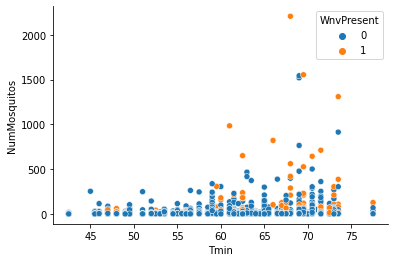

In [42]:
sns.scatterplot(x='Tmin', y='NumMosquitos', data=X_train_EDA, hue='WnvPresent');

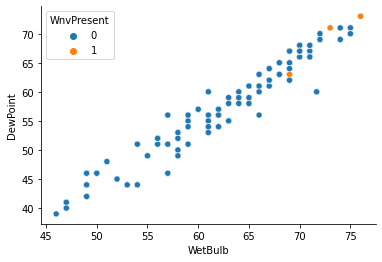

In [43]:
sns.scatterplot(x='WetBulb', y='DewPoint', data=X_train_EDA, hue='WnvPresent');

## Lineplot of Weather conditions vs mosquitos
- tried lineplot of the different original and featured engineered weather conditions based on year-mth as index
- some of them showed a pattern, could be helpful in presentation and why are included in our model

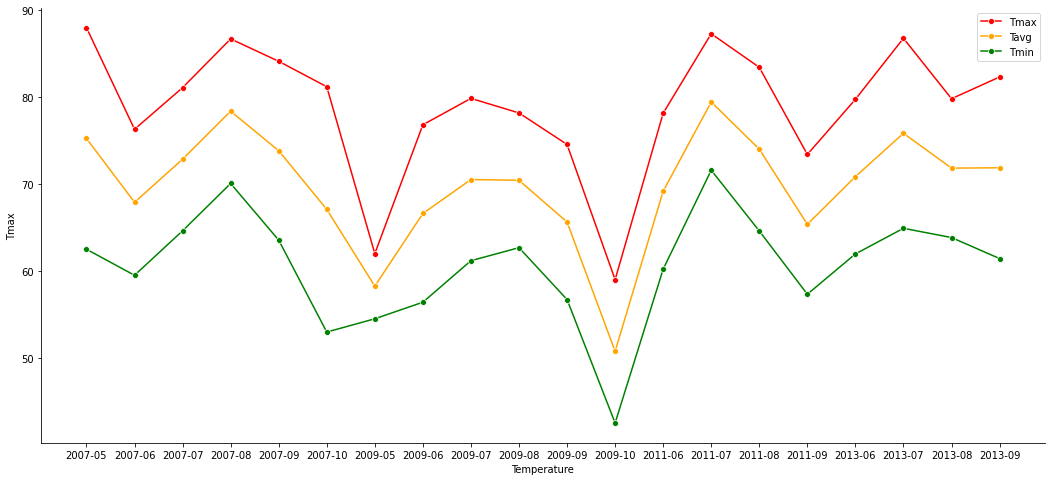

In [44]:
EDA_yearmth = X_train_EDA.groupby('year-mth').mean()

plt.figure(figsize=(18,8))
sns.lineplot(x = EDA_yearmth.index , y= 'Tmax', data= EDA_yearmth, ci=False,  marker='o', color='red', label='Tmax');
sns.lineplot(x = EDA_yearmth.index , y= 'Tavg', data= EDA_yearmth, ci=False,  marker='o', color='orange', label='Tavg')
sns.lineplot(x = EDA_yearmth.index , y= 'Tmin', data= EDA_yearmth, ci=False,  marker='o', color='green', label='Tmin')
plt.xticks(fontsize=10);
plt.xlabel('Temperature')
plt.legend()

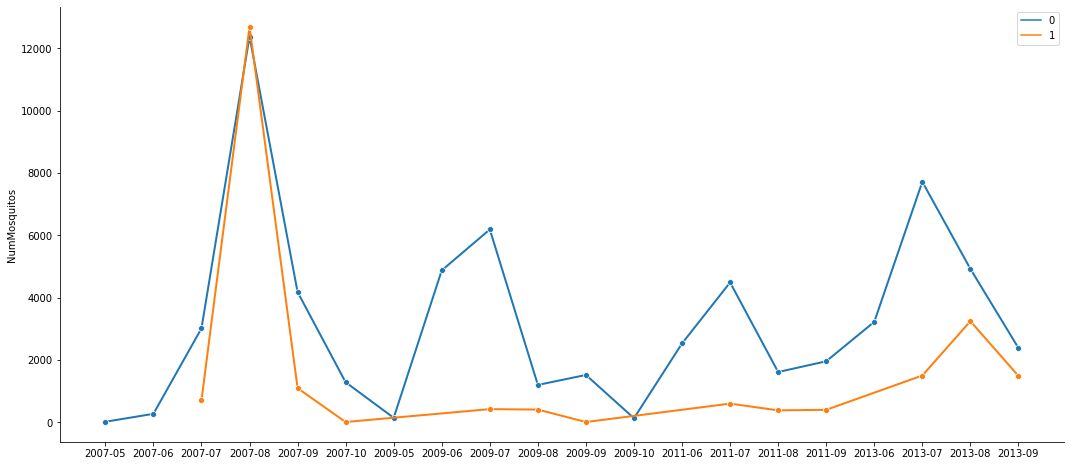

In [45]:
yrmth_wnv_group = X_train_EDA.groupby(['year-mth', 'WnvPresent']).sum()

x_index_yrmth = [keys for keys, values in yrmth_wnv_group.index]
hue_wnv = [values for keys, values in yrmth_wnv_group.index]

# hue = 'WnvPresent'

plt.figure(figsize=(18,8))
sns.lineplot(x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
plt.legend()
plt.xticks(fontsize=10);
# can start to observe that the number of mosquitoes are different for different location

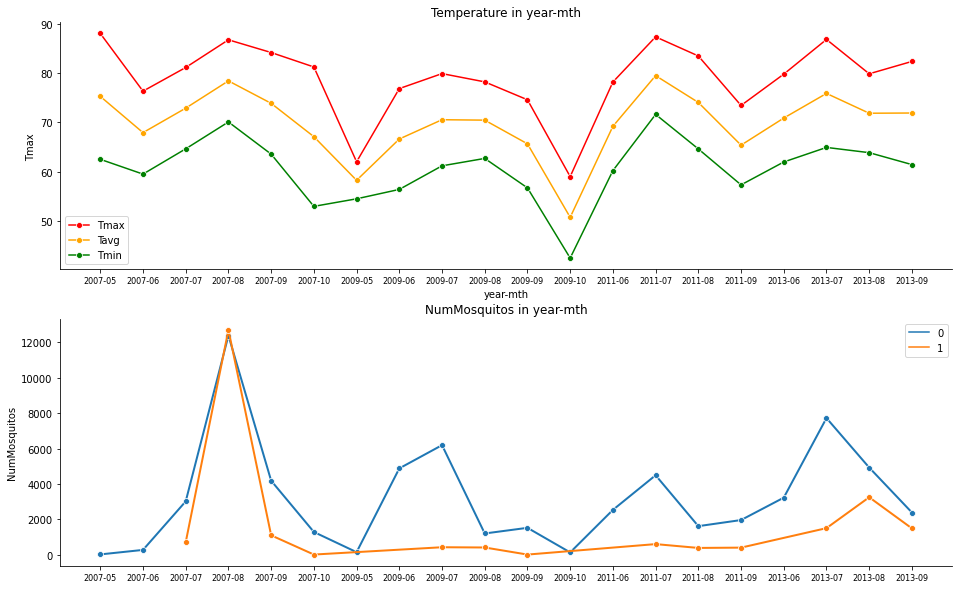

In [46]:
# decided to combine the temperature lock with mosquitoes

## this is the same as the 2 above, they are the subplot version...
## probably for presentation?

#lineplot based on dates
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);

sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'Tmax', data= EDA_yearmth, ci=False,  marker='o', color='red', label='Tmax');
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'Tavg', data= EDA_yearmth, ci=False,  marker='o', color='orange', label='Tavg')
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'Tmin', data= EDA_yearmth, ci=False,  marker='o', color='green', label='Tmin')
axes[0].set_title("Temperature in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

sns.lineplot(ax=axes[1], x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)


ValueError: ignored

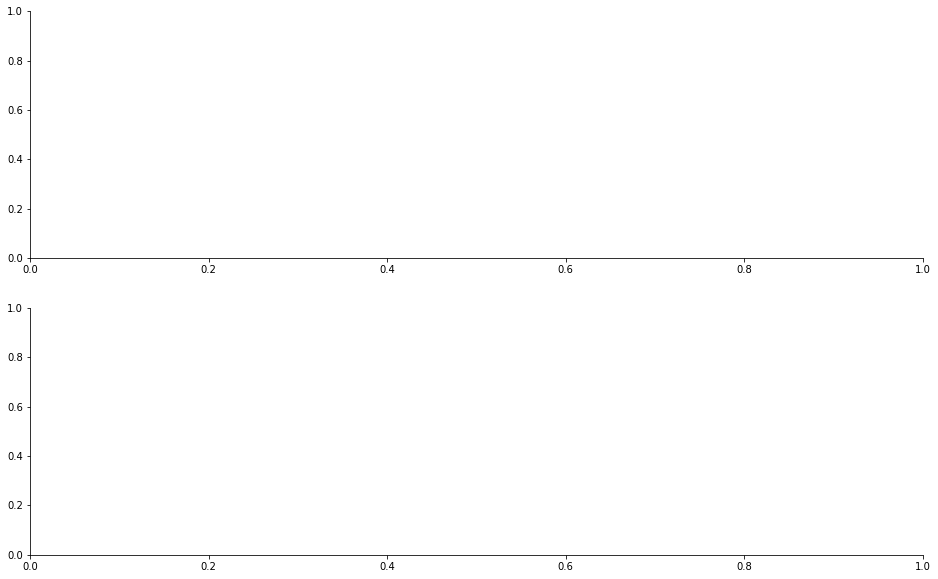

In [47]:
#lineplot based on dates
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);

sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'Tavg_lag1_r18', data= EDA_yearmth, ci=False,  marker='o', color='red', label='Tmax');
axes[0].set_title("Tavg_lag1_r18 Temperature in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

sns.lineplot(ax=axes[1], x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)


In [ ]:
#lineplot based on dates
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);

sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'WetBulb', data= EDA_yearmth, ci=False,  marker='o', color='purple', label='WetBulb');
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'DewPoint', data= EDA_yearmth, ci=False,  marker='o', color='blue', label='DewPoint')
axes[0].set_title("Wet Bulb & DewPoint in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

sns.lineplot(ax=axes[1], x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)


In [ ]:
#lineplot based on dates
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);

sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'Humidity_r28', data= EDA_yearmth, ci=False,  marker='o', color='magenta', label='Humidity_r28')
axes[0].set_title("Humidity_r28 in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

sns.lineplot(ax=axes[1], x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)

In [ ]:
#lineplot based on dates
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);

sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'Humidity', data= EDA_yearmth, ci=False,  marker='o', color='olive', label='Humidity')
axes[0].set_title("Humidity in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

sns.lineplot(ax=axes[1], x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)

In [ ]:
#lineplot based on dates
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);

sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'SunHours', data= EDA_yearmth, ci=False,  marker='o', color='brown', label='Sunhours')
axes[0].set_title("SunHours in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

sns.lineplot(ax=axes[1], x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)

In [ ]:
#lineplot based on dates
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);

sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'PrecipTotal', data= EDA_yearmth, ci=False,  marker='o', color='purple', label='Sunhours')
axes[0].set_title("PrecipTotal in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

sns.lineplot(ax=axes[1], x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)

In [ ]:
EDA_yearmth.head(3)

In [ ]:
#lineplot based on dates
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharey=False);

sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'SeaLevel', data= EDA_yearmth, ci=False,  marker='o', color='navy', label='SeaLevel')
sns.lineplot(ax=axes[0], x = EDA_yearmth.index , y= 'StnPressure', data= EDA_yearmth, ci=False,  marker='o', color='skyblue', label='StnPressure')
axes[0].set_title("SeaLevel & StnPressure in year-mth");
axes[0].xaxis.set_tick_params(labelsize=8)

sns.lineplot(ax=axes[1], x = x_index_yrmth, y = "NumMosquitos", data =yrmth_wnv_group.sort_index(level=0), ci=False, hue=hue_wnv, marker='o', lw=2)
axes[1].set_title("NumMosquitos in year-mth");
axes[1].xaxis.set_tick_params(labelsize=8)

## Total count of mosquitos Observed
- then hue by 'Wnv Present'

In [ ]:
# thought of doing this, but not sure how to plot
# probably abandon this
latlong_table = pd.DataFrame(X_train_EDA.groupby(["Latitude", "Longitude",'WnvPresent'])[[ 'NumMosquitos']].mean())
latlong_table

## Spray Map

In [ ]:
origin = [41.65, -87.90] 
upperRight = [42.05, -87.55]

mapdata = np.loadtxt("/content/mapdata_copyright_openstreetmap_contributors.txt")

numPoints = 50
long_nooutlier = spray[spray['Longitude'] > -88]
lats = long_nooutlier['Latitude']
longs = long_nooutlier['Longitude']

intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth

plt.figure(figsize=(12,12));
plt.imshow(mapdata, cmap=plt.get_cmap('Greys_r'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
ax = sns.kdeplot(x=longs, y=lats, cmap="GnBu", shade=True, bw_adjust=.5, thresh=0, alpha=0.7, legend=True)
ax.collections[0].set_alpha(0)

traps = X_train_EDA[['Longitude', 'Latitude']].drop_duplicates()
traps = traps[(-87.9 < traps['Longitude']) & ( traps['Longitude'] < -87.55) & (traps['Latitude'] > 41.65)]
lats = traps['Latitude']
longs = traps['Longitude']
plt.scatter(x=longs, y=lats, c='b', s=30, label='Traps');

present = X_train_EDA[X_train_EDA['WnvPresent'] == 1][['Longitude', 'Latitude']].drop_duplicates()
wnv_present = present[(-87.9 < present['Longitude']) & ( present['Longitude'] < -87.55)]
lats = wnv_present['Latitude']
longs = wnv_present['Longitude']
plt.scatter(x=longs, y=lats, c='r', s=30 ,marker='x', label='WNV Present');

plt.legend(fontsize=15);

### Creating a DataFrame to show where Spray and Train are close in proximity:

In [ ]:
#creating a spray_sub df using relevant columns to
#compare spray data with train data:
#spray data only starts at 2011

In [ ]:
#making a copy of spray to compare against train daata
spray_sub = spray.copy()
spray_sub['Date'] = [pd.to_datetime(date) for date in spray_sub['Date']]
spray_sub.drop(columns='Time', inplace=True)
spray_sub

In [ ]:
spray_sub.dtypes

In [ ]:
spray_sub.rename(columns={'Latitude':'latitude_sp',
                          'Longitude':'longitude_sp'
                         }, inplace=True)
spray_sub

In [ ]:
#making a copy of train to compare against spray data
train_sub = X_train_EDA.copy()
train_sub.columns

In [ ]:
train_sub = train_sub.drop(['AddressAccuracy', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'Heat/Cool', 'sunset', 'sunrise', 'SunHours', 'isRainy', 'has_Rain',
       'Humidity', 'Tavg_lag1_r18', 'AvgSpeed_lag1_r22', 'SunHours_lag24_r4',
       'Humidity_r28', 'year-mth'], axis=1)
train_sub

In [ ]:
train_sub.rename(columns = {'Latitude':'latitude_tr',
                            'Longitude':'longitude_tr',
                            'Trap':'trap_tr',
                            'NumMosquitos':'num_mosquitos_tr',
                            'WnvPresent':'wnv_present_tr'
                           }, inplace=True)

train_sub
train_sub['Date'] = [pd.to_datetime(date) for date in train_sub['Date']]

In [ ]:
from scipy.spatial.distance import cdist
from geopy.distance import geodesic

In [ ]:
train_sub.columns

In [ ]:
def closest_point(point, points):
    if len(points) <= 0 or point == None:
        return None
    #finding closest point from a list of points
    return points[cdist([point], points).argmin()]

spray_sub['point'] = list(zip(spray_sub['latitude_sp'], spray_sub['longitude_sp']))
train_sub['point'] = list(zip(train_sub['latitude_tr'], train_sub['longitude_tr']))

train_sub['closest_spray'] = train_sub.apply(lambda row: closest_point(row['point'], list(spray_sub.loc[spray_sub['Date'] == row['Date']]['point'])), axis=1)
train_sub['closest_distance'] = train_sub.apply(lambda row: geodesic(row['point'], row['closest_spray']).m if row['closest_spray'] != None else 0, axis=1)
train_sub['closest_distance'] = train_sub['closest_distance'].astype(float)

train_sub['closest_distance']

In [ ]:
train_spray = train_sub.copy()
print(train_spray['closest_distance'].isnull().sum())
train_spray.head()

In [ ]:
train_spray.dtypes

In [ ]:
train_spray[train_spray[
    ['closest_spray',
     'closest_distance']].notnull().all(axis=1)].sort_values(by='closest_distance')

According to our research, spray travels only about 90metres (300FT), so we only want to look at values of closest spray less than our threshold of 150m. Other areas in the train dataset that are out of this range will not have been influenced by mosquito spray.

In [ ]:
train_spray = train_spray[(train_spray['closest_distance'] < 150) & (train_spray['closest_distance'] > 0)]
train_spray.set_index('Date', inplace=True)
#sorting by ascending distance
train_spray.sort_values(by = 'closest_distance',ascending=True)[['closest_spray','closest_distance']]

In [ ]:
trspr_corr = train_spray[['num_mosquitos_tr', 'wnv_present_tr', 'closest_distance']].corr()
trspr_corr

In [ ]:
sns.heatmap(trspr_corr, cbar=True, annot=True);

In [ ]:
train_spray_all = train_sub.copy()

In [ ]:
spray_year = [2011,2013]
# for year in spray_year:
#     target = 'wnv_present_tr'
#     color='black'
#     # train_spray['year'] = train_spray.apply(lambda row: row.index.year, axis=1)

#     fig, ax1 = plt.subplots(figsize=(10,4))
#     temp_df = train_spray_all[train_spray_all['Year']==year].groupby(['Week'])[target].sum().to_frame()

#     sns.lineplot(x=temp_df.index, y=temp_df[target],
#                          ci=None, color=color, label=f'{target}', ax=ax1)
#     ax1.set_ylabel(f'{target}', fontsize=13)
#     ax1.legend(loc=1)

#     for date in train_spray_all[train_spray_all['Year'] == year].groupby('Week').mean().index:
#         plt.axvline(date, linestyle='--', color='black', alpha=0.5, label='Spray')


#     plt.legend([f'{target}', 'Spray'])
#     plt.title(f'{target} in {year}')
#     plt.tight_layout()
# spray['Year'] = pd.to_datetime(spray['Date']).apply(lambda x: x.year)
# spray['Week'] = pd.to_datetime(spray['Date']).apply(lambda x: x.week)


for year in spray_year:
    target = 'wnv_present_tr'
    color='black'
    # train_spray['year'] = train_spray.apply(lambda row: row.index.year, axis=1)

    fig, ax1 = plt.subplots(figsize=(10,4))
    temp_df = train_sub[train_sub['Year']==year].groupby(['Week'])[target].sum().to_frame()

    sns.lineplot(x=temp_df.index, y=temp_df[target],
                         ci=None, color=color, label=f'{target}', ax=ax1)
    ax1.set_ylabel(f'{target}', fontsize=13)
    ax1.legend(loc=1)

    for date in train_spray[train_spray['Year'] == year].groupby('Week').mean().index:
        plt.axvline(date, linestyle='--', color='black', alpha=0.5, label='Spray')


    plt.legend([f'{target}', 'Spray'])
    plt.title(f'{target} in {year}')
    plt.tight_layout()

## Correlations

In [ ]:
X_train_EDA_corr = X_train_EDA[['NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'Heat/Cool', 'SunHours', 'isRainy',
       'Humidity','Month', 'Week', 'WnvPresent']].corr()
plt.figure(figsize = (25,15))
sns.heatmap(X_train_EDA_corr, cmap=plt.cm.PuOr, annot=True, annot_kws={'size':10},
);

In [ ]:
def cross_corr(feature):
    """
    Takes a given weather feature and creates a cross correlation matrix of WNVPresent
    and that feature rolled and lagged to various degrees. 
    Each feature is lagged i days, and rolled j days where i+j <= 28. This is because 28 days is the maximum buffer 
    we have for weather data before the first trap gets sampled.
    E.g. A feature lagged by 10 days will be rolled 1-17 more days.
    Every such combination of roll and lag within 28 days will be correlated against WnvPresent, 
    and plotted onto a heatmap. The combination that produces the highest absolute correlation will have its
    correlation coefficient annotated on the heatmap.
    """
    tmp = X_train_EDA[['WnvPresent', feature, 'Date']].copy()
    # tmp['Date'] = tmp['Date'].astype(str)
    coef_list = []
    for i in range(1,28):    # lag feature by i days
        row = []
        for j in range(1, (29-i)):    # roll feature by j days
            label = feature + '_lag' + str(i) + '_r' + str(j)
            # create the lagged and rolled feature
            weather[label] = weather[feature].shift(i).rolling(j).mean()
            # merge it with the main table
            tmp = tmp.merge(weather[[label, 'Date']], on='Date')
            # calculate correlation for WNV and new feature
            coef = np.corrcoef([tmp['WnvPresent'], tmp[label]])[0,1]
            # store correlation coefs for i-th lag with j-th roll in a list
            row.append(coef)
        row = np.array(row)
        row.resize(27)
        # store all coefficients from each lagged day into a bigger list
        coef_list.append(row)
    # create correlation table
    corr_map = pd.DataFrame(coef_list, 
                            columns=['roll_'+ str(i) for i in range(1,28)], 
                            index=['lag_'+ str(i) for i in range(1,28)])
    # inverting it to make heatmap easier to read
    corr_map = corr_map.iloc[::-1]
    # extract the largest absolute correlation found to annotate in heatmap later
    maximum = abs(corr_map.values).max()
    labels = corr_map.applymap(lambda x: str(round(x,3)) if abs(x) == maximum else '')
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(corr_map, annot=labels, annot_kws = {'fontsize':8}, 
                fmt='', square=True, cbar_kws={"shrink": .70}, cmap=plt.cm.PuOr),
    ax.tick_params(labelsize=8)
    ax.set_title('Cross correlation map for {} with WNVPresent'.format(feature))

In [ ]:
cols_to_corr = [
                'Tavg',
                'Humidity',
                'AvgSpeed',
                'DewPoint',
                'WetBulb',
                ]

In [ ]:
for col in cols_to_corr:
  cross_corr(col)

### Lagged features

In [48]:
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Heat/Cool,sunset,sunrise,SunHours,isRainy,Humidity
0,2007-05-01,83,51.0,67.00,14.0,51,56.0,448,1849,,0.0,29.140,29.82,1.7,27,9.2,2.00,2007-05-01 18:49:00,2007-05-01 04:48:00,841.0,0,56.44
1,2007-05-02,59,42.5,50.75,-3.0,42,47.0,447,1850,BR,0.0,29.410,30.09,13.0,4,13.4,-14.25,2007-05-02 18:50:00,2007-05-02 04:47:00,843.0,0,71.86
2,2007-05-03,66,47.0,56.50,2.0,40,48.0,446,1851,,0.0,29.425,30.12,11.7,7,11.9,-8.50,2007-05-03 18:51:00,2007-05-03 04:46:00,845.0,0,53.89
3,2007-05-04,66,50.0,58.00,4.0,41,50.0,444,1852,RA,0.0,29.335,30.05,10.4,8,10.8,-7.00,2007-05-04 18:52:00,2007-05-04 04:44:00,848.0,1,53.08
4,2007-05-05,66,53.5,59.75,5.0,38,49.0,443,1853,,0.0,29.430,30.10,11.7,7,12.0,-5.25,2007-05-05 18:53:00,2007-05-05 04:43:00,850.0,0,44.36


In [49]:
weather['DewPoint_Roll22Lag1'] = weather['DewPoint'].shift(1).rolling(22).mean()
weather['WetBulb_Roll16Lag7'] = weather['WetBulb'].shift(7).rolling(16).mean()
weather['AvgSpeed_Roll22Lag5'] = weather['AvgSpeed'].shift(5).rolling(22).mean()
weather['Humidity_Roll16Lag1'] = weather['Humidity'].shift(1).rolling(16).mean()
weather['isRainy_Roll6Lag21'] = weather['isRainy'].shift(21).rolling(6).mean()
weather['PrecipTotal_Roll1Lag5'] = weather['PrecipTotal'].shift(5).rolling(1).mean()
weather['ResultSpeed_Roll23Lag5'] = weather['ResultSpeed'].shift(5).rolling(23).mean()
weather['AvgSpeed_Roll22Lag5'] = weather['AvgSpeed'].shift(5).rolling(22).mean()
weather['Heat/Cool_Roll12Lag12'] = weather['Heat/Cool'].shift(12).rolling(12).mean()
weather['Tavg_Roll12Lag12'] = weather['Tavg'].shift(12).rolling(12).mean()

In [50]:
lagged_cols = [
               'DewPoint_Roll22Lag1',
               'WetBulb_Roll16Lag7',
               'AvgSpeed_Roll22Lag5',
               'Humidity_Roll16Lag1',
               'isRainy_Roll6Lag21',
               'PrecipTotal_Roll1Lag5',
               'ResultSpeed_Roll23Lag5',
               'AvgSpeed_Roll22Lag5',
               'Heat/Cool_Roll12Lag12',
               'Tavg_Roll12Lag12',
               'Date'
]

In [51]:
weather['Date'] = pd.to_datetime(weather['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [52]:
test

,Id,Date,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Heat/Cool,sunset,sunrise,SunHours,isRainy,Humidity
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41,T002,41.954690,-87.800991,9,86,63.5,74.75,7.0,56,64.0,416,1926,,0.00,29.310,29.99,8.9,18,10.0,9.75,2008-06-11 19:26:00,2008-06-11 04:16:00,910.0,0,52.08
1,2,2008-06-11,CULEX RESTUANS,41,T002,41.954690,-87.800991,9,86,63.5,74.75,7.0,56,64.0,416,1926,,0.00,29.310,29.99,8.9,18,10.0,9.75,2008-06-11 19:26:00,2008-06-11 04:16:00,910.0,0,52.08
2,3,2008-06-11,CULEX PIPIENS,41,T002,41.954690,-87.800991,9,86,63.5,74.75,7.0,56,64.0,416,1926,,0.00,29.310,29.99,8.9,18,10.0,9.75,2008-06-11 19:26:00,2008-06-11 04:16:00,910.0,0,52.08
3,4,2008-06-11,CULEX SALINARIUS,41,T002,41.954690,-87.800991,9,86,63.5,74.75,7.0,56,64.0,416,1926,,0.00,29.310,29.99,8.9,18,10.0,9.75,2008-06-11 19:26:00,2008-06-11 04:16:00,910.0,0,52.08
4,5,2008-06-11,CULEX TERRITANS,41,T002,41.954690,-87.800991,9,86,63.5,74.75,7.0,56,64.0,416,1926,,0.00,29.310,29.99,8.9,18,10.0,9.75,2008-06-11 19:26:00,2008-06-11 04:16:00,910.0,0,52.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,21,T054C,41.925652,-87.633590,8,72,64.5,68.25,10.0,61,63.0,549,1732,TSRA RA BR,0.32,29.065,29.78,7.2,17,7.9,3.25,2014-10-02 17:32:00,2014-10-02 05:49:00,703.0,1,77.65
116289,116290,2014-10-02,CULEX TERRITANS,21,T054C,41.925652,-87.633590,8,72,64.5,68.25,10.0,61,63.0,549,1732,TSRA RA BR,0.32,29.065,29.78,7.2,17,7.9,3.25,2014-10-02 17:32:00,2014-10-02 05:49:00,703.0,1,77.65
116290,116291,2014-10-02,CULEX TARSALIS,21,T054C,41.925652,-87.633590,8,72,64.5,68.25,10.0,61,63.0,549,1732,TSRA RA BR,0.32,29.065,29.78,7.2,17,7.9,3.25,2014-10-02 17:32:00,2014-10-02 05:49:00,703.0,1,77.65
116291,116292,2014-10-02,UNSPECIFIED CULEX,21,T054C,41.925652,-87.633590,8,72,64.5,68.25,10.0,61,63.0,549,1732,TSRA RA BR,0.32,29.065,29.78,7.2,17,7.9,3.25,2014-10-02 17:32:00,2014-10-02 05:49:00,703.0,1,77.65


In [53]:
X_train = X_train.merge(weather[lagged_cols], left_on='Date', right_on='Date')
X_train_EDA = X_train_EDA.merge(weather[lagged_cols], left_on='Date', right_on='Date')
X_val = X_val.merge(weather[lagged_cols], left_on='Date', right_on='Date')
test = test.merge(weather[lagged_cols], left_on='Date', right_on='Date')

In [54]:
X_train

,Date,Trap,Latitude,Longitude,Species,Block,AddressAccuracy,NumMosquitos,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Heat/Cool,sunset,sunrise,SunHours,isRainy,Humidity,year-mth,Year,Month,Week,DewPoint_Roll22Lag1,WetBulb_Roll16Lag7,AvgSpeed_Roll22Lag5,Humidity_Roll16Lag1,isRainy_Roll6Lag21,PrecipTotal_Roll1Lag5,ResultSpeed_Roll23Lag5,AvgSpeed_Roll22Lag5,Heat/Cool_Roll12Lag12,Tavg_Roll12Lag12
0,2013-09-06,T048,41.867108,-87.654224,CULEX PIPIENS,11,8,12,86,59.5,72.75,5.0,58,64.0,522,1819,,0.0,29.410,30.11,4.7,20,6.0,7.75,2013-09-06 18:19:00,2013-09-06 05:22:00,777.0,0,59.86,2013-09,2013,9,36,61.227273,66.9375,7.109091,65.50875,0.333333,1.400000e-01,5.630435,7.109091,7.187500,72.187500
1,2013-09-06,T027,41.984809,-87.728492,CULEX PIPIENS,58,8,19,86,59.5,72.75,5.0,58,64.0,522,1819,,0.0,29.410,30.11,4.7,20,6.0,7.75,2013-09-06 18:19:00,2013-09-06 05:22:00,777.0,0,59.86,2013-09,2013,9,36,61.227273,66.9375,7.109091,65.50875,0.333333,1.400000e-01,5.630435,7.109091,7.187500,72.187500
2,2013-09-06,T128,41.704572,-87.565666,CULEX PIPIENS/RESTUANS,24,8,10,86,59.5,72.75,5.0,58,64.0,522,1819,,0.0,29.410,30.11,4.7,20,6.0,7.75,2013-09-06 18:19:00,2013-09-06 05:22:00,777.0,0,59.86,2013-09,2013,9,36,61.227273,66.9375,7.109091,65.50875,0.333333,1.400000e-01,5.630435,7.109091,7.187500,72.187500
3,2013-09-06,T212,41.680946,-87.535198,CULEX PIPIENS,37,8,5,86,59.5,72.75,5.0,58,64.0,522,1819,,0.0,29.410,30.11,4.7,20,6.0,7.75,2013-09-06 18:19:00,2013-09-06 05:22:00,777.0,0,59.86,2013-09,2013,9,36,61.227273,66.9375,7.109091,65.50875,0.333333,1.400000e-01,5.630435,7.109091,7.187500,72.187500
4,2013-09-06,T230,41.904194,-87.756155,CULEX PIPIENS,13,9,6,86,59.5,72.75,5.0,58,64.0,522,1819,,0.0,29.410,30.11,4.7,20,6.0,7.75,2013-09-06 18:19:00,2013-09-06 05:22:00,777.0,0,59.86,2013-09,2013,9,36,61.227273,66.9375,7.109091,65.50875,0.333333,1.400000e-01,5.630435,7.109091,7.187500,72.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5673,2009-06-03,T900,41.974689,-87.890615,CULEX PIPIENS/RESTUANS,70,63,254,61,45.0,53.00,-12.0,39,46.0,418,1921,,0.0,29.445,30.15,10.5,4,10.7,-12.00,2009-06-03 19:21:00,2009-06-03 04:18:00,903.0,0,58.88,2009-06,2009,6,23,45.545455,52.9375,9.740909,56.29000,0.333333,0.000000e+00,7.769565,9.740909,-5.083333,59.916667
5674,2007-08-03,T215,41.686398,-87.531635,CULEX PIPIENS/RESTUANS,38,8,50,90,71.0,80.50,7.0,56,66.0,447,1909,,0.0,29.335,30.02,2.7,3,5.7,15.50,2007-08-03 19:09:00,2007-08-03 04:47:00,862.0,0,43.07,2007-08,2007,8,31,59.136364,63.8125,8.195455,61.39750,0.333333,0.000000e+00,6.278261,8.195455,6.354167,71.354167
5675,2007-08-16,T128,41.704572,-87.565666,CULEX PIPIENS/RESTUANS,48,16,98,77,66.0,71.50,-1.0,64,67.0,500,1852,BR,0.0,29.305,29.97,3.6,1,5.7,6.50,2007-08-16 18:52:00,2007-08-16 05:00:00,832.0,0,77.24,2007-08,2007,8,33,64.681818,69.2500,6.222727,66.11875,0.166667,5.551115e-17,4.556522,6.222727,11.875000,76.875000
5676,2007-08-16,T128,41.704572,-87.565666,CULEX PIPIENS,408,136,821,77,66.0,71.50,-1.0,64,67.0,500,1852,BR,0.0,29.305,29.97,3.6,1,5.7,6.50,2007-08-16 18:52:00,2007-08-16 05:00:00,832.0,0,77.24,2007-08,2007,8,33,64.681818,69.2500,6.222727,66.11875,0.166667,5.551115e-17,4.556522,6.222727,11.875000,76.875000


# Polynomial Features

In [55]:
X_poly_train = X_train._get_numeric_data()

In [56]:
poly = PolynomialFeatures(include_bias=False, degree=2)
X_poly = poly.fit_transform(X_poly_train)
X_poly.shape

(5678, 702)

In [57]:
X_poly = pd.DataFrame(X_poly,columns=poly.get_feature_names(X_poly_train.columns))

In [58]:
X_poly_corrs = X_poly.corrwith(y_train)

In [59]:
abs(X_poly_corrs).sort_values(ascending=False).head(20)

PrecipTotal isRainy                0.155088
PrecipTotal Heat/Cool              0.152081
PrecipTotal ResultDir              0.150647
DewPoint PrecipTotal               0.149109
WetBulb PrecipTotal                0.148675
Tmax PrecipTotal                   0.148188
Tavg PrecipTotal                   0.148042
Tmin PrecipTotal                   0.147776
PrecipTotal Humidity               0.146217
PrecipTotal SunHours               0.146211
Sunset PrecipTotal                 0.145902
Latitude PrecipTotal               0.145121
PrecipTotal DewPoint_Roll22Lag1    0.145031
Longitude PrecipTotal              0.144988
PrecipTotal                        0.144961
PrecipTotal Year                   0.144865
PrecipTotal StnPressure            0.144795
PrecipTotal SeaLevel               0.144786
PrecipTotal WetBulb_Roll16Lag7     0.144466
PrecipTotal Tavg_Roll12Lag12       0.144378
dtype: float64

In [60]:
X_train['Precip_X_DewPointRL'] = X_train['PrecipTotal'] * X_train['DewPoint_Roll22Lag1']
X_val['Precip_X_DewPointRL'] = X_val['PrecipTotal'] * X_val['DewPoint_Roll22Lag1']
test['Precip_X_DewPointRL'] = test['PrecipTotal'] * test['DewPoint_Roll22Lag1']

X_train['Precip_X_WetBulbRL'] = X_train['PrecipTotal'] * X_train['WetBulb_Roll16Lag7']
X_val['Precip_X_WetBulbRL'] = X_val['PrecipTotal'] * X_val['WetBulb_Roll16Lag7']
test['Precip_X_WetBulbRL'] = test['PrecipTotal'] * test['WetBulb_Roll16Lag7']

X_train['Precip_X_TavgRL'] = X_train['PrecipTotal'] * X_train['Tavg_Roll12Lag12']
X_val['Precip_X_TavgRL'] = X_val['PrecipTotal'] * X_val['Tavg_Roll12Lag12']
test['Precip_X_TavgRL'] = test['PrecipTotal'] * test['Tavg_Roll12Lag12']

X_train['Precip_X_ResultDir'] = X_train['PrecipTotal'] * X_train['ResultDir']
X_val['Precip_X_ResultDir'] = X_val['PrecipTotal'] * X_val['ResultDir']
test['Precip_X_ResultDir'] = test['PrecipTotal'] * test['ResultDir']

X_train['Precip_X_Latitude'] = X_train['PrecipTotal'] * X_train['Latitude']
X_val['Precip_X_Latitude'] = X_val['PrecipTotal'] * X_val['Latitude']
test['Precip_X_Latitude'] = test['PrecipTotal'] * test['Latitude']

X_train['Precip_X_Longitude'] = X_train['PrecipTotal'] * X_train['Longitude']
X_val['Precip_X_Longitude'] = X_val['PrecipTotal'] * X_val['Longitude']
test['Precip_X_Longitude'] = test['PrecipTotal'] * test['Longitude']

# Dummy Features

Here we create dummy variables on features we've found to be imortant from our EDA.

## Species

We decided to dummy `Species` into 4 categories: Culex Pipiens/Restuans, Culex Pipiens, Culex Restuans and the rest as one group. This is due to earlier section where we found these 2 species to be the main disease harbouring species for the West Nile Virus.

In [61]:
X_train['Species_predummy'] = X_train['Species'].map({
    'CULEX PIPIENS/RESTUANS': 3, 
    'CULEX PIPIENS': 2, 
    'CULEX RESTUANS': 1
})
X_train['Species_predummy'] = X_train['Species_predummy'].fillna(0)

X_val['Species_predummy'] = X_val['Species'].map({
    'CULEX PIPIENS/RESTUANS': 3, 
    'CULEX PIPIENS': 2, 
    'CULEX RESTUANS': 1
})
X_val['Species_predummy'] = X_val['Species_predummy'].fillna(0)

test['Species_predummy'] = test['Species'].map({
    'CULEX PIPIENS/RESTUANS': 3, 
    'CULEX PIPIENS': 2, 
    'CULEX RESTUANS': 1
})
test['Species_predummy'] = test['Species_predummy'].fillna(0)

In [62]:
test['Species'].value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
UNSPECIFIED CULEX         14345
CULEX ERRATICUS           14345
Name: Species, dtype: int64

In [63]:
X_train['Species_predummy'].value_counts()

3.0    2558
1.0    1624
2.0    1294
0.0     202
Name: Species_predummy, dtype: int64

In [64]:
species_dummies_train = pd.get_dummies(X_train['Species_predummy'], prefix='Species', drop_first=True)
species_dummies_val = pd.get_dummies(X_val['Species_predummy'], prefix='Species', drop_first=True)
species_dummies_test = pd.get_dummies(test['Species_predummy'], prefix='Species', drop_first=True)

In [65]:
species_dummies_train

,Species_1.0,Species_2.0,Species_3.0
0,0,1,0
1,0,1,0
2,0,0,1
3,0,1,0
4,0,1,0
...,...,...,...
5673,0,0,1
5674,0,0,1
5675,0,0,1
5676,0,1,0


In [66]:
X_train = pd.concat([X_train, species_dummies_train], axis=1)
X_val = pd.concat([X_val, species_dummies_val], axis=1)
test = pd.concat([test, species_dummies_test], axis=1)

In [67]:
cols_to_drop = ['Date', 'Species', 'Block', 'AddressAccuracy', 'NumMosquitos', 'sunset', 'sunrise', 'year-mth', 'Species_predummy', 'CodeSum', 'Tmax', 'Tmin']

In [68]:
cols_to_drop_test = ['Id', 'Date', 'Species', 'Block', 'AddressAccuracy', 'sunset', 'sunrise', 'Species_predummy', 'CodeSum', 'Tmax', 'Tmin']

In [69]:
X_train.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'Species', 'Block',
       'AddressAccuracy', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'Heat/Cool', 'sunset', 'sunrise', 'SunHours', 'isRainy', 'Humidity',
       'year-mth', 'Year', 'Month', 'Week', 'DewPoint_Roll22Lag1',
       'WetBulb_Roll16Lag7', 'AvgSpeed_Roll22Lag5', 'Humidity_Roll16Lag1',
       'isRainy_Roll6Lag21', 'PrecipTotal_Roll1Lag5', 'ResultSpeed_Roll23Lag5',
       'AvgSpeed_Roll22Lag5', 'Heat/Cool_Roll12Lag12', 'Tavg_Roll12Lag12',
       'Precip_X_DewPointRL', 'Precip_X_WetBulbRL', 'Precip_X_TavgRL',
       'Precip_X_ResultDir', 'Precip_X_Latitude', 'Precip_X_Longitude',
       'Species_predummy', 'Species_1.0', 'Species_2.0', 'Species_3.0'],
      dtype='object')

In [70]:
X_train = X_train.drop(columns = cols_to_drop)

In [71]:
y_train = pd.DataFrame(y_train)

In [72]:
X_val = X_val.drop(columns = cols_to_drop)

In [73]:
y_val = pd.DataFrame(y_val)

In [74]:
test = test.drop(columns=cols_to_drop_test)

In [75]:
X_train.to_csv('/content/X_train.csv', index=False)
y_train.to_csv('/content/y_train.csv', index=False)
X_val.to_csv('/content/X_val.csv', index=False)
y_val.to_csv('/content/y_val.csv', index=False)
test.to_csv('/content/test_new.csv', index=False)

In [76]:
X_train_EDA.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'Species', 'Block',
       'AddressAccuracy', 'NumMosquitos', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'Heat/Cool', 'sunset', 'sunrise', 'SunHours', 'isRainy', 'Humidity',
       'year-mth', 'Year', 'Month', 'Week', 'WnvPresent',
       'DewPoint_Roll22Lag1', 'WetBulb_Roll16Lag7', 'AvgSpeed_Roll22Lag5',
       'Humidity_Roll16Lag1', 'isRainy_Roll6Lag21', 'PrecipTotal_Roll1Lag5',
       'ResultSpeed_Roll23Lag5', 'AvgSpeed_Roll22Lag5',
       'Heat/Cool_Roll12Lag12', 'Tavg_Roll12Lag12'],
      dtype='object')

In [78]:
test.shape

(116293, 38)